## Architecture
- Input : 28 * 28 * 1
- Convolution layer 1 with 32 filters - Output: 28 * 28 * 32 (32 filter maps)
- Max pooling with 2 * 2 matrix - Output: 14 * 14 * 32 (Shrinked)
- Convolution layer 2 with 64 filters of depth 32 - Output: 14 * 14 * 64
- Max pooling with 2 * 2 matrix - Output: 7 * 7 * 64
- FC1 
- FC2 
- Softmax

In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <459875AA-DE2C-366B-9C44-90D4B3887080> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
mps_device = torch.device("mps")

## Data

In [3]:
image_path = './'
mnist_data = torchvision.datasets.MNIST(root = image_path,
                                        train = True,
                                        transform = transforms.ToTensor(),
                                        download = True)
mnist_test_data = torchvision.datasets.MNIST(root = image_path, 
                                             train = False,
                                             transform = transforms.ToTensor(),
                                             download = True)

In [223]:
mnist_data.data.dtype

torch.uint8

In [4]:
mnist_valid_dataset = Subset(mnist_data, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_data, torch.arange(10000, len(mnist_data)))

In [221]:
mnist_valid_dataset[1][0].dtype

torch.float32

In [6]:
batch_size = 64
torch.manual_seed(1) # To produce same set of 64 batch on each time when we run 
data = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)

# Why to shuffle validation?? What is the difference if I dont batch and calculate validation performance
# entirely on the validation set after each epoch ?
data_vl = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=False)

In [7]:
next(iter(data))[0].shape

torch.Size([64, 1, 28, 28])

## Model

In [8]:
model = nn.Sequential()
model.add_module('conv1', 
                 nn.Conv2d( in_channels=1, out_channels=32,
                 kernel_size=5, padding=2)) # Padding=2 which makes it as `same mode`
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2)) # default: stride=kernel_size=2
model.add_module('conv2',
                 nn.Conv2d( in_channels=32, out_channels=64,
                 kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten(1))
model.add_module('fc1', nn.Linear(3136, 1024)) # 3136 is determined by inspecting the output of prev layer :)
model.add_module('relu3', nn.ReLU())
# DROPOUT: leave half of the neuron units while training on each iteration. But batch wise or epoch wise?
model.add_module('dropout', nn.Dropout(p=0.5))  # Inverse dropout will be carried out during training phase
model.add_module('fc2', nn.Linear(1024, 10))
#model.add_module('relu4', nn.ReLU()) ## Mistakely added this lead to accuracy very low
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [9]:
model = model.to(mps_device)

In [10]:
x = torch.ones((64,1, 28, 28), device=mps_device)
model(x).shape

torch.Size([64, 10])

## Training

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_accuracy = [0] * epoch
    validation_loss = [0] * epoch
    validation_accuracy = [0] * epoch
    for i in range(epoch):
        model.train() # to ENABLE dropout while training
        for x_batch, y_batch in data:
            x_batch = x_batch.to(mps_device)
            y_batch = y_batch.to(mps_device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += loss.item() * x_batch.size(0)
            soft_pred = torch.softmax(pred, axis=1) # why is it not done?
            
            is_crt = (torch.argmax(soft_pred, dim=1) == y_batch).to(torch.float32).sum().cpu()
            train_accuracy[i] += is_crt

        train_loss[i] /= len(data.dataset)
        train_accuracy[i] /= len(data.dataset)
        
        model.eval() # to AVOID dropout while inference
        
        # Why dont we calculate the validation error/accuracy after an entire epoch? Is performance a reason?
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(mps_device)
                y_batch = y_batch.to(mps_device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                validation_loss[i] += loss.item() * x_batch.size(0)
                soft_pred = torch.softmax(pred, axis=1) # why is it not done?
                is_crt = (torch.argmax(soft_pred, dim=1) == y_batch).sum().to(torch.float32).cpu()
                validation_accuracy[i] += is_crt
            validation_loss[i] /= len(data_vl.dataset)
            validation_accuracy[i] /= len(data_vl.dataset)
        print(f"Epoch: {i+1}, Accuracy - train: {train_accuracy[i]}, validation: {validation_accuracy[i]}")
    return train_loss, train_accuracy, validation_loss, validation_accuracy



In [12]:
torch.manual_seed(1)
epoch = 20
train_loss, train_accuracy, validation_loss, validation_accuracy = train(model, epoch, data, data_vl)

Epoch: 1, Accuracy - train: 0.9506199955940247, validation: 0.9811999797821045
Epoch: 2, Accuracy - train: 0.9853000044822693, validation: 0.9851999878883362
Epoch: 3, Accuracy - train: 0.9902200102806091, validation: 0.982699990272522
Epoch: 4, Accuracy - train: 0.9920200109481812, validation: 0.989300012588501
Epoch: 5, Accuracy - train: 0.9929999709129333, validation: 0.9883000254631042
Epoch: 6, Accuracy - train: 0.9944599866867065, validation: 0.987500011920929
Epoch: 7, Accuracy - train: 0.9960600137710571, validation: 0.9896000027656555
Epoch: 8, Accuracy - train: 0.9959999918937683, validation: 0.9878000020980835
Epoch: 9, Accuracy - train: 0.9963799715042114, validation: 0.9883999824523926
Epoch: 10, Accuracy - train: 0.9964600205421448, validation: 0.9912999868392944
Epoch: 11, Accuracy - train: 0.9975200295448303, validation: 0.991100013256073
Epoch: 12, Accuracy - train: 0.9973800182342529, validation: 0.9900000095367432
Epoch: 13, Accuracy - train: 0.9977800250053406, vali

Text(0, 0.5, '$Accuracy$')

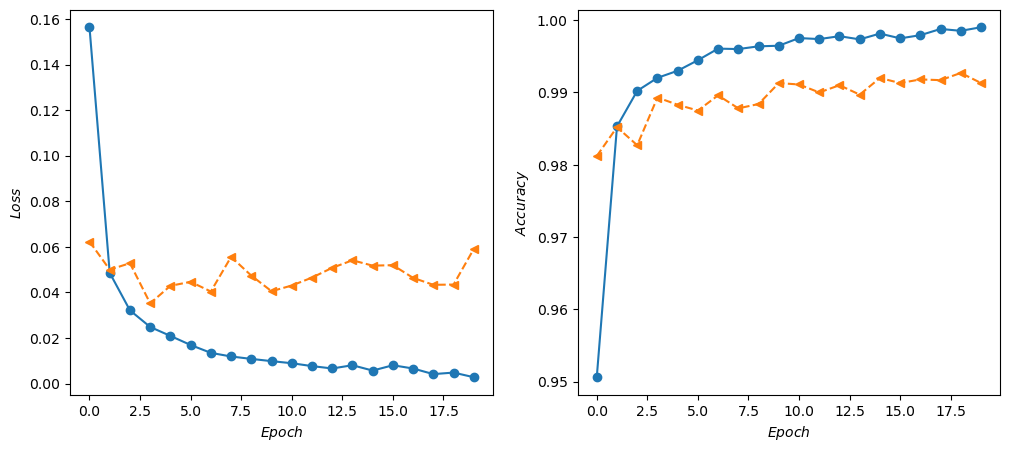

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), train_loss, '-o', label="Train Loss")
plt.plot(np.arange(epoch), validation_loss, '--<', label="Validation Loss")
plt.xlabel("$Epoch$")
plt.ylabel("$Loss$")

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), train_accuracy, '-o', label="Train Accuracy")
plt.plot(np.arange(epoch), validation_accuracy, '--<', label="Validation Accuracy")
plt.xlabel("$Epoch$")
plt.ylabel("$Accuracy$")

## Test data accuracy

In [259]:
mnist_test_data.data[0].dtype

torch.uint8

In [260]:
mnist_test_data[0][0].dtype

torch.float32

In [16]:
len(mnist_test_data)

10000

In [84]:
data_test = DataLoader(mnist_test_data, 64, shuffle=True)

total_crt = 0
with torch.no_grad():
    for x_batch, y_batch in data_test:
        x_batch = x_batch.to(mps_device)
        y_batch = y_batch.to(mps_device)
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        soft_pred = torch.softmax(pred, axis=1)
        is_crt = (torch.argmax(soft_pred, axis=1) == y_batch).float().sum()
        total_crt += is_crt
    print(f"Accuracy: {total_crt/len(data_test.dataset):.4f}")

Accuracy: 0.9932


In [85]:
total_crt

tensor(9932., device='mps:0')

In [156]:
model = model.to(mps_device)
data_test = DataLoader(mnist_test_data, 10000, shuffle=False)

total_crt = 0
with torch.no_grad():
    for x_batch, y_batch in data_test:
        print(x_batch.shape)
        x_batch = x_batch.to(mps_device)
        y_batch = y_batch.to(mps_device)
        pred = model(x_batch)
        print(pred)
        loss = loss_fn(pred, y_batch)
        soft_pred = torch.softmax(pred, axis=1)
        is_crt = (torch.argmax(soft_pred, axis=1) == y_batch).float().sum()
        total_crt += is_crt
    print(f"Accuracy: {total_crt/len(data_test.dataset):.4f}")

torch.Size([10000, 1, 28, 28])
tensor([[-37.6836, -19.1679, -17.8474,  ...,  42.5817, -36.9515, -18.8134],
        [-10.7249, -13.9031,  35.2150,  ..., -31.3361, -15.8908, -30.5881],
        [-26.1027,  32.3364, -27.1926,  ..., -17.1892, -11.1988, -25.5374],
        ...,
        [-43.9979, -17.6347, -33.0978,  ..., -25.9862, -14.4071, -18.7628],
        [-25.4065, -27.3832, -34.0300,  ..., -22.3598,  -1.8935, -17.1660],
        [-10.2998, -21.0205, -21.6235,  ..., -33.4993, -13.6961, -20.9885]],
       device='mps:0')
Accuracy: 0.9932


In [239]:
model = model.to('cpu')
testing = mnist_test_data.data.unsqueeze(1).to(torch.float32)/255
proba= model(testing)
proba

tensor([[-37.6836, -19.1679, -17.8474,  ...,  42.5817, -36.9514, -18.8134],
        [-10.7249, -13.9031,  35.2149,  ..., -31.3361, -15.8908, -30.5881],
        [-26.1026,  32.3364, -27.1926,  ..., -17.1892, -11.1988, -25.5374],
        ...,
        [-43.9979, -17.6347, -33.0978,  ..., -25.9862, -14.4071, -18.7628],
        [-25.4065, -27.3831, -34.0300,  ..., -22.3598,  -1.8935, -17.1660],
        [-10.2998, -21.0205, -21.6235,  ..., -33.4993, -13.6961, -20.9885]],
       grad_fn=<AddmmBackward0>)

### Why only 9894 are correct, wheras in earlier batch wise calculation 9932 are correct ?
- Reason : For some reason, the mnist_test_data is not scaled to [0-1] because of which there was issue. After dividing by 255, the range is 0-1 (which is used during training), the issue solved
- But why it is not scaled to 0-1 despite scaled in the batchwise method above? 
    - Look above - when indexing directly it is scaled, but not when accessing via `.data`

In [240]:
torch.softmax(proba, dim=1)

tensor([[1.3843e-35, 1.5222e-27, 5.7014e-27,  ..., 1.0000e+00, 2.8787e-35,
         2.1700e-27],
        [1.1183e-20, 4.6593e-22, 1.0000e+00,  ..., 1.2509e-29, 6.3835e-23,
         2.6431e-29],
        [4.1709e-26, 1.0000e+00, 1.4024e-26,  ..., 3.0994e-22, 1.2385e-19,
         7.3405e-26],
        ...,
        [4.1752e-39, 1.1750e-27, 2.2622e-34,  ..., 2.7736e-31, 2.9634e-26,
         3.8031e-28],
        [1.0559e-24, 1.4628e-25, 1.8989e-28,  ..., 2.2222e-23, 1.7187e-14,
         4.0034e-21],
        [1.5485e-18, 3.4196e-23, 1.8712e-23,  ..., 1.3017e-28, 5.1870e-20,
         3.5307e-23]], grad_fn=<SoftmaxBackward0>)

In [241]:
pred = torch.argmax(nn.Softmax( dim=1)(proba), axis=1)


In [230]:
(pred == mnist_test_data.targets).float().mean()

tensor(0.9932)

In [243]:
from sklearn.metrics import  classification_report

In [244]:
print(classification_report(pred, mnist_test_data.targets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      1.00      1142
           2       0.99      0.99      0.99      1029
           3       0.99      1.00      0.99      1007
           4       0.99      0.99      0.99       984
           5       0.99      0.99      0.99       894
           6       0.99      1.00      0.99       954
           7       0.99      0.99      0.99      1034
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1002

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

